In [ ]:
pip install earthengine-api

In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-saadlkhder02')

In [ ]:
# D√©finir la r√©gion F√®s-Mekn√®s (rectangle approximatif)
roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])

# D√©finir la p√©riode
start_date = "2018-01-01"
end_date = "2025-04-05"


In [ ]:
# Load Landsat 8 imagery
landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
    .filterBounds(roi_fes_meknes) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt("CLOUD_COVER", 10))  # Filter out cloudy images

# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(["B5", "B4"]).rename("NDVI")
    return image.addBands(ndvi)

# Apply the NDVI function to the image collection
landsat_ndvi = landsat.map(calculate_ndvi)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# Charger la collection Landsat 8
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(roi_fes_meknes) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt("CLOUD_COVER", 10))

# V√©rifier si la collection contient des images
landsat_size = landsat.size().getInfo()
if landsat_size == 0:
    raise ValueError("Aucune image trouv√©e avec les crit√®res de s√©lection.")

print(f"{landsat_size} images trouv√©es dans la collection")

# Fonction pour calculer le NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(["SR_B5", "SR_B4"]).rename("NDVI")
    return image.addBands(ndvi)

# Appliquer la fonction NDVI
landsat_ndvi = landsat.map(calculate_ndvi)

# R√©cup√©rer les donn√©es de NDVI
try:
    # Obtenir les informations de r√©gion (cette op√©ration est asynchrone)
    ndvi_time_series = landsat_ndvi.getRegion(
        geometry=roi_fes_meknes,
        scale=100,
        crs='EPSG:4326'
    ).getInfo()  # getInfo() force l'ex√©cution de la requ√™te

    # Convertir en DataFrame pandas
    import pandas as pd
    headers = ndvi_time_series[0]
    data = ndvi_time_series[1:]
    df = pd.DataFrame(data, columns=headers)

    # Traitement des donn√©es
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df['NDVI'] = pd.to_numeric(df['NDVI'])
    df = df.dropna(subset=['NDVI'])

    # Sauvegarder
    df.to_csv("ndvi_time_series.csv", index=False)
    print("Fichier CSV cr√©√© avec succ√®s")

except ee.EEException as e:
    print(f"Erreur Earth Engine: {str(e)}")
except Exception as e:
    print(f"Erreur inattendue: {str(e)}")
    import matplotlib.pyplot as plt
import pandas as pd



560 images trouv√©es dans la collection
Erreur Earth Engine: ImageCollection.getRegion: Too many values: 5205042 points x 20 bands x 560 images > 1048576.


In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm




# D√©finir la g√©om√©trie approximative de F√®s-Mekn√®s
roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])

# D√©finir la p√©riode
start_date = "2018-01-01"
end_date = "2025-01-01"

# Charger la collection Landsat 8
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(roi_fes_meknes) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt("CLOUD_COVER", 10))

# Fonction pour calculer NDVI moyen pour chaque image
def get_ndvi_feature(image):
    ndvi = image.normalizedDifference(["SR_B5", "SR_B4"]).rename("NDVI")
    date = image.date().format("YYYY-MM-dd")
    mean_dict = ndvi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi_fes_meknes,
        scale=100,
        maxPixels=1e9
    )
    return ee.Feature(None, {
        'date': date,
        'NDVI': mean_dict.get('NDVI')
    })

# Appliquer la fonction √† chaque image
ndvi_fc = landsat.map(get_ndvi_feature)

# Extraire la liste de Features
features = ndvi_fc.toList(ndvi_fc.size())
ndvi_data = []
for i in tqdm(range(features.size().getInfo()) , desc="Extraction NDVI"):
    f = ee.Feature(features.get(i)).getInfo()
    props = f['properties']
    if 'NDVI' in props and props['NDVI'] is not None:
        ndvi_data.append({
            'date': props['date'],
            'NDVI': props['NDVI']
        })

# Cr√©er un DataFrame propre
df = pd.DataFrame(ndvi_data)
df["date"] = pd.to_datetime(df["date"])
df["NDVI"] = pd.to_numeric(df["NDVI"], errors="coerce")
df = df.dropna()

# Regrouper par date (au cas o√π il y a plusieurs NDVI par jour)
df_mean = df.groupby("date").mean().reset_index()

# Ajouter un lissage (moyenne mobile)
df_mean["NDVI_smoothed"] = df_mean["NDVI"].rolling(window=5, center=True).mean()

# Sauvegarder les deux CSV
df.to_csv("ndvi_raw_fes_meknes.csv", index=False)
df_mean.to_csv("ndvi_grouped_smoothed_fes_meknes.csv", index=False)
print("‚úÖ CSV export√©s avec succ√®s")

# Tracer la courbe liss√©e
plt.figure(figsize=(12, 6))
plt.plot(df_mean["date"], df_mean["NDVI_smoothed"], color="green", label="NDVI liss√©")
plt.title("NDVI moyen liss√© - F√®s-Mekn√®s (2018-2025)")
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ndvi_lisse_fes_meknes.png")
plt.show()


Extraction NDVI:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 522/540 [16:37<00:13,  1.30it/s]

URL du thumbnail g√©n√©r√© : https://earthengine.googleapis.com/v1/projects/ee-saadlkhder02/thumbnails/83e459914261b81e1ff7e8c26dfe3f31-3323b6896098483c50f7ae7e1a92cd73:getPixels
‚úÖ Carte sauvegard√©e avec succ√®s sous le nom : carte_ndvi_moyen_fes_meknes.png


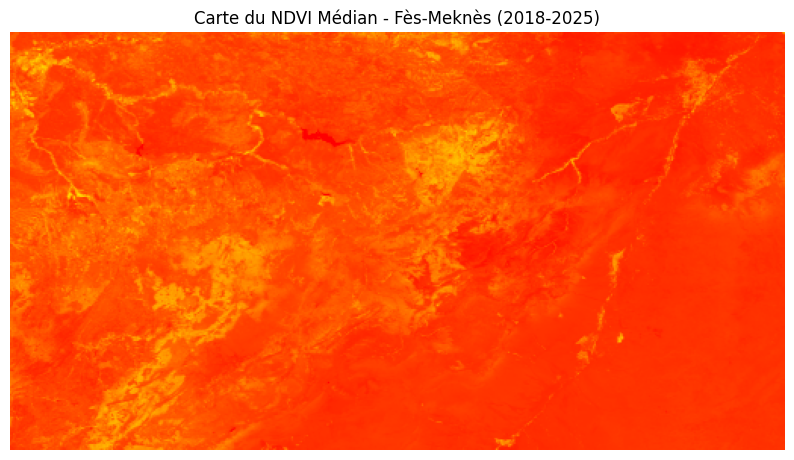

In [ ]:
import ee
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


# 1. D√©finir la r√©gion et la p√©riode
roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])
start_date = "2018-01-01"
end_date = "2025-01-01" # Fin de la p√©riode d'analyse

# 2. Obtenir la collection d'images Landsat 8 et calculer le NDVI
def calculate_ndvi(image):
    return image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

landsat_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(roi_fes_meknes) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
    .map(calculate_ndvi)

# 3. Cr√©er une seule image en prenant la m√©diane de toutes les images
# La m√©diane est robuste aux valeurs extr√™mes (nuages r√©siduels, etc.)
median_ndvi = landsat_collection.median()

# 4. D√©finir les param√®tres de visualisation pour le NDVI
# Palette de couleurs allant du rouge (v√©g√©tation faible) au vert (v√©g√©tation forte)
vis_params_ndvi = {
    'min': 0.0,
    'max': 0.8,
    'palette': ['red', 'yellow', 'green']
}

# 5. Obtenir l'URL d'une image miniature (thumbnail)
thumbnail_url = median_ndvi.getThumbURL({
    'dimensions': 512,  # Taille de l'image en pixels
    'region': roi_fes_meknes,
    'format': 'png',
    **vis_params_ndvi # Int√©gration des param√®tres de visualisation
})

print("URL du thumbnail g√©n√©r√© :", thumbnail_url)

# 6. T√©l√©charger et afficher l'image
try:
    response = requests.get(thumbnail_url)
    img = Image.open(BytesIO(response.content))

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title('Carte du NDVI M√©dian - F√®s-Mekn√®s (2018-2025)')
    plt.axis('off') # Cacher les axes X et Y

    # Sauvegarder la carte
    nom_carte_sortie = "carte_ndvi_moyen_fes_meknes.png"
    plt.savefig(nom_carte_sortie, dpi=300, bbox_inches='tight')
    print(f"‚úÖ Carte sauvegard√©e avec succ√®s sous le nom : {nom_carte_sortie}")

    plt.show()

except Exception as e:
    print(f"Erreur lors du t√©l√©chargement ou de l'affichage de l'image : {e}")

In [ ]:
!pip install folium --upgrade # Upgrade to the latest version of folium

üîÑ Traitement de l'ann√©e 2018


Ann√©e 2018: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 364/364 [33:45<00:00,  5.56s/it]


üîÑ Traitement de l'ann√©e 2019


Ann√©e 2019: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 364/364 [41:34<00:00,  6.85s/it]


üîÑ Traitement de l'ann√©e 2020


Ann√©e 2020: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 365/365 [34:49<00:00,  5.72s/it]


üîÑ Traitement de l'ann√©e 2021


Ann√©e 2021: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 364/364 [40:54<00:00,  6.74s/it]


üîÑ Traitement de l'ann√©e 2022


Ann√©e 2022: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 364/364 [38:39<00:00,  6.37s/it]


üîÑ Traitement de l'ann√©e 2023


Ann√©e 2023: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 364/364 [36:05<00:00,  5.95s/it]


üîÑ Traitement de l'ann√©e 2024


Ann√©e 2024: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 365/365 [35:52<00:00,  5.90s/it]


üîÑ Traitement de l'ann√©e 2025


Ann√©e 2025: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 143/143 [06:25<00:00,  2.70s/it]


‚úÖ Extraction termin√©e et CSV export√©.


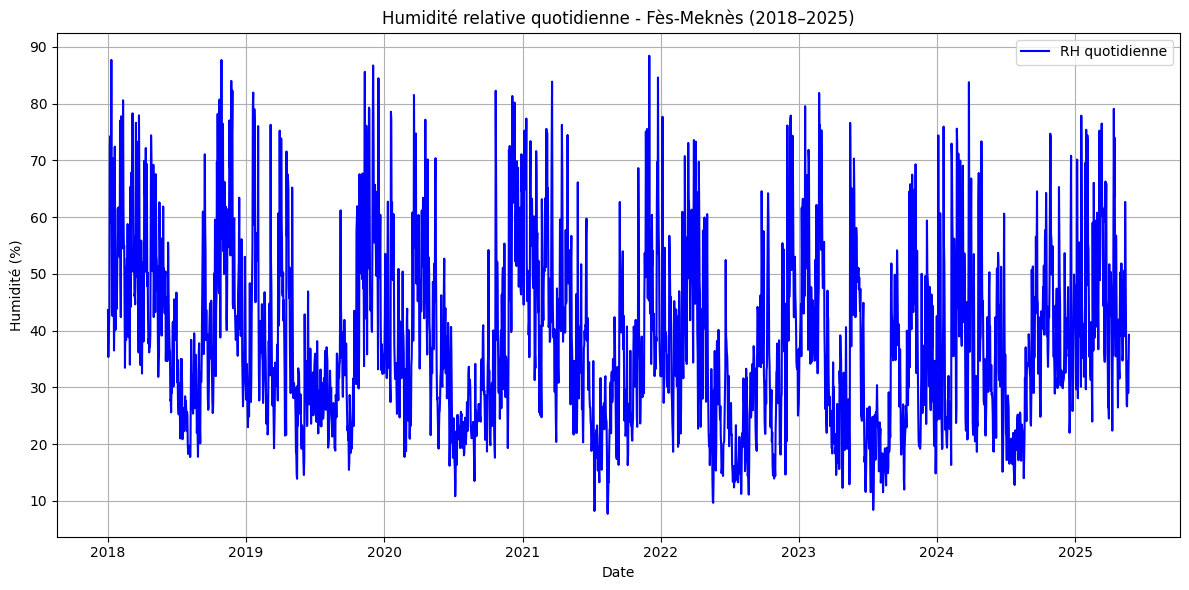

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])
years = list(range(2018, 2026))  # 2018 √† 2025 inclus

all_rh = []

for year in years:
    print(f"üîÑ Traitement de l'ann√©e {year}")
    start = f"{year}-01-01"
    end = f"{year}-12-31"

    era5 = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") \
        .filterBounds(roi_fes_meknes) \
        .filterDate(start, end) \
        .filter(ee.Filter.calendarRange(12, 12, 'hour')) \
        .select(["temperature_2m", "dewpoint_temperature_2m"])

    def compute_relative_humidity(image):
        temp = image.select("temperature_2m").subtract(273.15)
        dew = image.select("dewpoint_temperature_2m").subtract(273.15)
        es = temp.multiply(17.625).divide(temp.add(243.04)).exp()
        ed = dew.multiply(17.625).divide(dew.add(243.04)).exp()
        rh = ed.divide(es).multiply(100).rename("RH")

        mean_rh = rh.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi_fes_meknes,
            scale=1000,
            maxPixels=1e9
        )

        return ee.Feature(None, {
            "date": image.date().format("YYYY-MM-dd"),
            "RH": mean_rh.get("RH")
        })

    rh_fc = era5.map(compute_relative_humidity)
    features = rh_fc.toList(rh_fc.size())
    for i in tqdm(range(features.size().getInfo()), desc=f"Ann√©e {year}"):
        f = ee.Feature(features.get(i)).getInfo()
        props = f["properties"]
        if "RH" in props and props["RH"] is not None:
            all_rh.append({
                "date": props["date"],
                "RH": props["RH"]
            })

# Convertir en DataFrame
df_rh = pd.DataFrame(all_rh)
df_rh["date"] = pd.to_datetime(df_rh["date"])
df_rh["RH"] = pd.to_numeric(df_rh["RH"], errors="coerce")
df_rh = df_rh.dropna()

# Sauvegarde
df_rh.to_csv("humidite_relative_fes_meknes.csv", index=False)
print("‚úÖ Extraction termin√©e et CSV export√©.")

# Graphique
plt.figure(figsize=(12, 6))
plt.plot(df_rh["date"], df_rh["RH"], color="blue", label="RH quotidienne")
plt.title("Humidit√© relative quotidienne - F√®s-Mekn√®s (2018‚Äì2025)")
plt.xlabel("Date")
plt.ylabel("Humidit√© (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("humidite_relative_fes_meknes.png", dpi=300)
plt.show()


Extraction pr√©cipitations: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2557/2557 [1:39:08<00:00,  2.33s/it]


S√©rie temporelle des pr√©cipitations export√©e


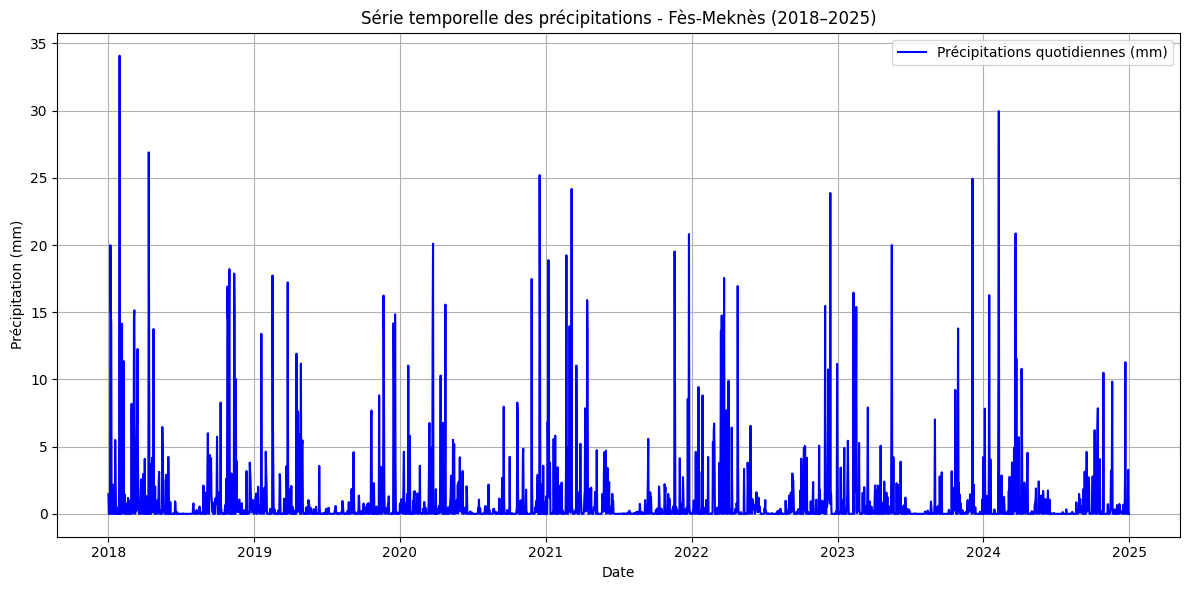

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


# D√©finir la r√©gion
roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])

# D√©finir la p√©riode d'analyse
start_date = "2018-01-01"
end_date = "2025-01-01"

# Charger la collection CHIRPS
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
    .filterBounds(roi_fes_meknes) \
    .filterDate(start_date, end_date) \
    .select("precipitation")

# Fonction pour extraire la pr√©cipitation moyenne par image
def extract_daily_precip(image):
    date = image.date().format("YYYY-MM-dd")
    mean_rain = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi_fes_meknes,
        scale=5000,
        maxPixels=1e9
    )
    return ee.Feature(None, {
        "date": date,
        "precipitation": mean_rain.get("precipitation")
    })

# Appliquer la fonction √† chaque image
rain_fc = chirps.map(extract_daily_precip)

# Extraire les donn√©es
features = rain_fc.toList(rain_fc.size())
rain_data = []
for i in tqdm(range(features.size().getInfo()), desc="Extraction pr√©cipitations"):
    f = ee.Feature(features.get(i)).getInfo()
    props = f["properties"]
    if "precipitation" in props and props["precipitation"] is not None:
        rain_data.append({
            "date": props["date"],
            "precipitation": props["precipitation"]
        })

# Convertir en DataFrame
df_rain = pd.DataFrame(rain_data)
df_rain["date"] = pd.to_datetime(df_rain["date"])
df_rain["precipitation"] = pd.to_numeric(df_rain["precipitation"], errors="coerce")
df_rain = df_rain.dropna()

# Sauvegarder le CSV
df_rain.to_csv("serie_precipitation_fes_meknes.csv", index=False)
print("S√©rie temporelle des pr√©cipitations export√©e")

# Tracer la courbe
plt.figure(figsize=(12, 6))
plt.plot(df_rain["date"], df_rain["precipitation"], color="blue", label="Pr√©cipitations quotidiennes (mm)")
plt.title("S√©rie temporelle des pr√©cipitations - F√®s-Mekn√®s (2018‚Äì2025)")
plt.xlabel("Date")
plt.ylabel("Pr√©cipitation (mm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("serie_precipitation_fes_meknes.png", dpi=300)
plt.show()


üîÑ Traitement de la temp√©rature pour l'ann√©e 2018


Extraction temp√©rature 2018: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 364/364 [33:58<00:00,  5.60s/it]


üîÑ Traitement de la temp√©rature pour l'ann√©e 2019


Extraction temp√©rature 2019: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 364/364 [33:03<00:00,  5.45s/it]


üîÑ Traitement de la temp√©rature pour l'ann√©e 2020


Extraction temp√©rature 2020: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 365/365 [33:02<00:00,  5.43s/it]


üîÑ Traitement de la temp√©rature pour l'ann√©e 2021


Extraction temp√©rature 2021: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 364/364 [32:15<00:00,  5.32s/it]


üîÑ Traitement de la temp√©rature pour l'ann√©e 2022


Extraction temp√©rature 2022: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 364/364 [31:16<00:00,  5.16s/it]


üîÑ Traitement de la temp√©rature pour l'ann√©e 2023


Extraction temp√©rature 2023: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 364/364 [33:47<00:00,  5.57s/it]


üîÑ Traitement de la temp√©rature pour l'ann√©e 2024


Extraction temp√©rature 2024: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 365/365 [33:19<00:00,  5.48s/it]


üîÑ Traitement de la temp√©rature pour l'ann√©e 2025


Extraction temp√©rature 2025: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 144/144 [06:41<00:00,  2.79s/it]


S√©rie temporelle de temp√©rature export√©e


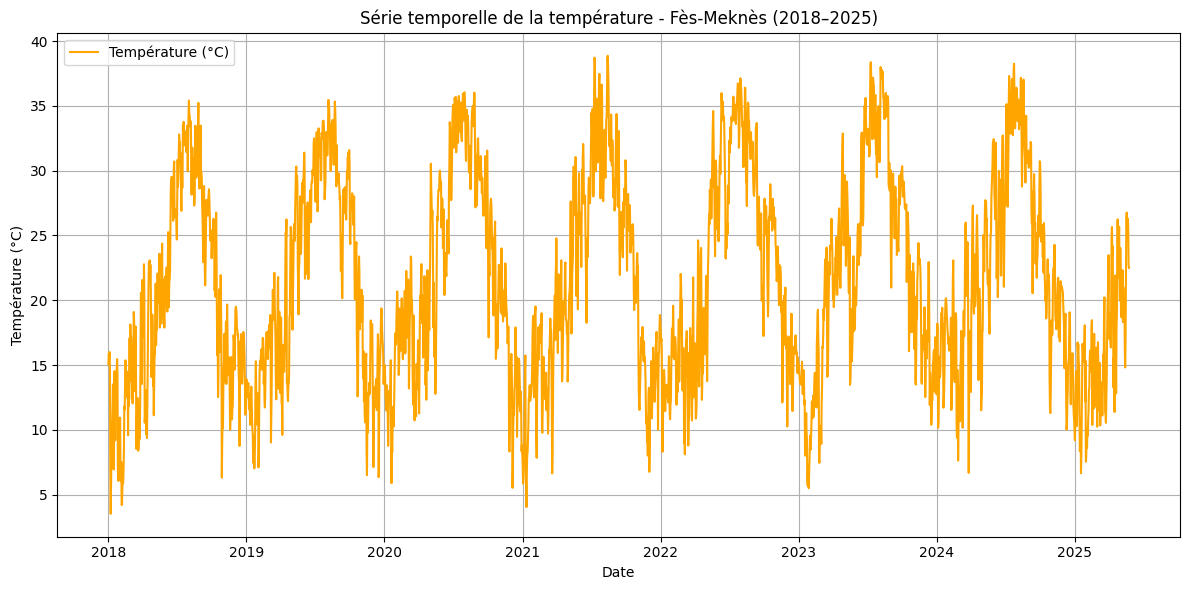

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialiser Earth Engine (si ce n'est pas d√©j√† fait dans votre session)
# ee.Authenticate() # Ex√©cutez si n√©cessaire
# ee.Initialize(project='ee-saadlkhder02') # Remplacez par votre projet

# D√©finir la r√©gion F√®s-Mekn√®s
roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])
years = list(range(2018, 2026)) # 2018 √† 2025 inclus

all_temp_data = [] # Liste pour agr√©ger les donn√©es de toutes les ann√©es

# Fonction pour extraire la temp√©rature moyenne par jour (identique √† la v√¥tre)
def extract_daily_temp(image):
    date = image.date().format("YYYY-MM-dd")
    temp_c = image.select("temperature_2m").subtract(273.15)  # Convertir en ¬∞C
    mean_temp = temp_c.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi_fes_meknes,
        scale=1000,
        maxPixels=1e9
    )
    return ee.Feature(None, {
        "date": date,
        "temperature": mean_temp.get("temperature_2m")
    })

for year in years:
    print(f"üîÑ Traitement de la temp√©rature pour l'ann√©e {year}")
    start_date_year = f"{year}-01-01"
    end_date_year = f"{year}-12-31" # S'assurer de prendre toute l'ann√©e

    era5 = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") \
        .filterBounds(roi_fes_meknes) \
        .filterDate(start_date_year, end_date_year) \
        .filter(ee.Filter.calendarRange(12, 12, 'hour')) \
        .select("temperature_2m")

    temp_fc_year = era5.map(extract_daily_temp)

    # Limiter le nombre d'√©l√©ments r√©cup√©r√©s par getInfo() √† la fois
    # En traitant ann√©e par ann√©e, la taille de la liste est plus g√©rable
    features_year = temp_fc_year.toList(temp_fc_year.size()) # .size() ici est pour l'ann√©e en cours

    for i in tqdm(range(features_year.size().getInfo()), desc=f"Extraction temp√©rature {year}"):
        f = ee.Feature(features_year.get(i)).getInfo()
        props = f["properties"]
        if "temperature" in props and props["temperature"] is not None:
            all_temp_data.append({
                "date": props["date"],
                "temperature": props["temperature"]
            })

# Convertir en DataFrame
df_temp = pd.DataFrame(all_temp_data)
df_temp["date"] = pd.to_datetime(df_temp["date"])
df_temp["temperature"] = pd.to_numeric(df_temp["temperature"], errors="coerce")
df_temp = df_temp.dropna()
df_temp = df_temp.sort_values(by='date') # S'assurer que les donn√©es sont tri√©es par date

# Sauvegarder le CSV
df_temp.to_csv("serie_temperature_fes_meknes.csv", index=False)
print("S√©rie temporelle de temp√©rature export√©e")

# Tracer la courbe (identique √† votre code)
plt.figure(figsize=(12, 6))
plt.plot(df_temp["date"], df_temp["temperature"], color="orange", label="Temp√©rature (¬∞C)")
plt.title("S√©rie temporelle de la temp√©rature - F√®s-Mekn√®s (2018‚Äì2025)")
plt.xlabel("Date")
plt.ylabel("Temp√©rature (¬∞C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("serie_temperature_fes_meknes.png", dpi=300)
plt.show()

In [ ]:
import pandas as pd

# Charger chaque s√©rie temporelle
df_ndvi = pd.read_csv("ndvi_grouped_smoothed_fes_meknes.csv")
df_precip = pd.read_csv("serie_precipitation_fes_meknes.csv")
df_temp = pd.read_csv("serie_temperature_fes_meknes.csv")
df_rh = pd.read_csv("humidite_relative_fes_meknes.csv")  # optionnel

# Convertir les dates en datetime
df_ndvi["date"] = pd.to_datetime(df_ndvi["date"])
df_precip["date"] = pd.to_datetime(df_precip["date"])
df_temp["date"] = pd.to_datetime(df_temp["date"])
df_rh["date"] = pd.to_datetime(df_rh["date"])


In [ ]:
# Fusion NDVI + Pr√©cipitations
df_all = pd.merge(df_ndvi, df_precip, on="date", how="inner")

# Fusion avec Temp√©rature
df_all = pd.merge(df_all, df_temp, on="date", how="inner")

#  Fusion avec Humidit√©
df_all = pd.merge(df_all, df_rh, on="date", how="inner")


In [ ]:
print(df_all.isnull().sum())



date             0
NDVI             0
NDVI_smoothed    4
precipitation    0
temperature      0
RH               0
dtype: int64


In [ ]:
df_all_cleaned = df_all.dropna(subset=['NDVI_smoothed'])
print(df_all_cleaned.isnull().sum()) # Pour v√©rifier

date             0
NDVI             0
NDVI_smoothed    0
precipitation    0
temperature      0
RH               0
dtype: int64


In [ ]:

# Exporter le DataFrame fusionn√© et nettoy√© en CSV
df_all_cleaned.to_csv("donnees1_fusionnees_fes_meknes_nettoyees.csv", index=False)

print("‚úÖ DataFrame fusionn√© et nettoy√© export√© avec succ√®s vers 'donnees_fusionnees_fes_meknes_nettoyees.csv'")

‚úÖ DataFrame fusionn√© et nettoy√© export√© avec succ√®s vers 'donnees_fusionnees_fes_meknes_nettoyees.csv'


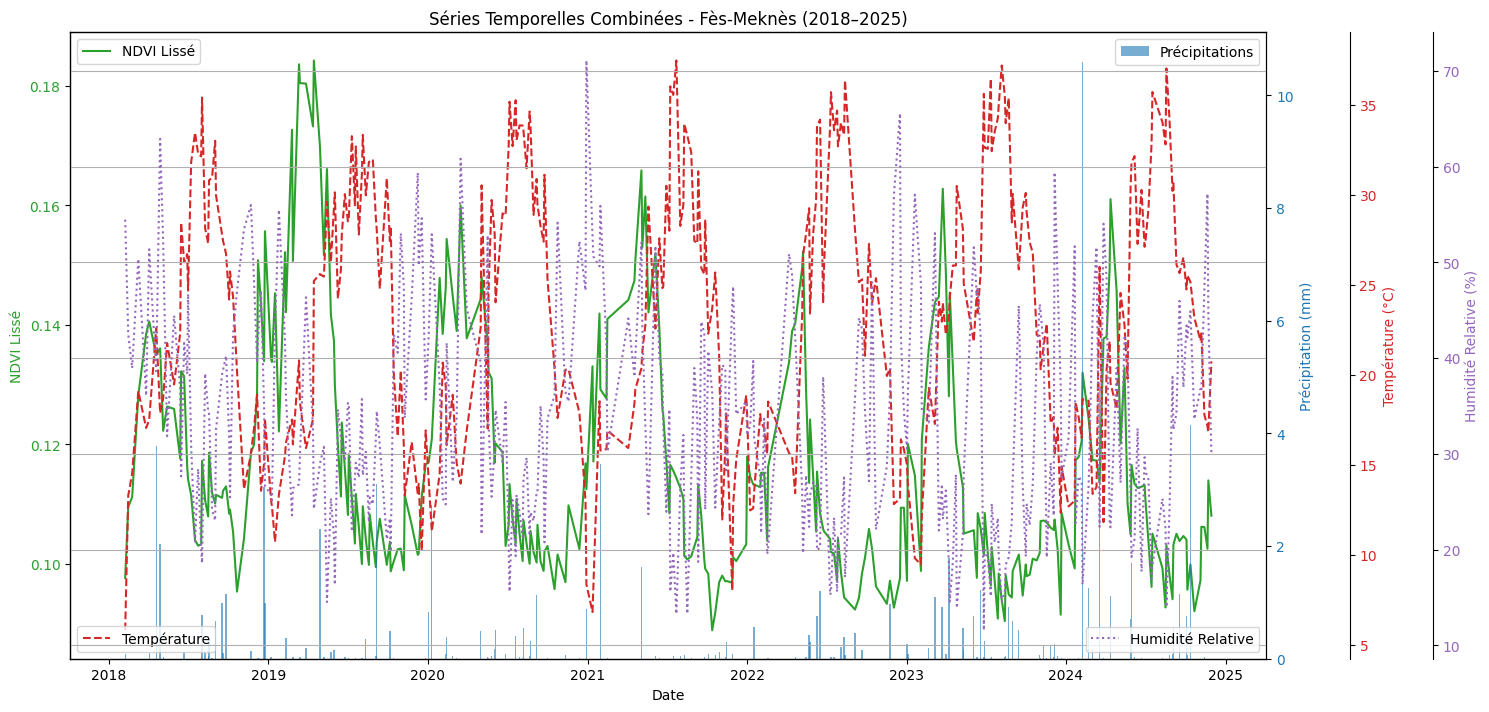

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd # Au cas o√π ce n'est pas d√©j√† import√© ou si vous red√©marrez cette section

# Assurez-vous que df_all_nettoye est votre DataFrame final fusionn√© et nettoy√©
# et que la colonne 'date' est bien au format datetime et est l'index (ou sera utilis√©e comme axe X)

# Si 'date' n'est pas l'index, mais une colonne :
# df_all_nettoye['date'] = pd.to_datetime(df_all_nettoye['date']) # S'assurer que c'est bien un datetime

fig, ax1 = plt.subplots(figsize=(15, 7))

# Axe 1 : NDVI liss√©
color = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('NDVI Liss√©', color=color)
ax1.plot(df_all_cleaned['date'], df_all_cleaned['NDVI_smoothed'], color=color, label='NDVI Liss√©')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Axe 2 : Pr√©cipitations
# On cr√©e un deuxi√®me axe Y qui partage le m√™me axe X (twinx)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Pr√©cipitation (mm)', color=color)
# Utiliser un graphique en barres pour les pr√©cipitations peut √™tre plus lisible
ax2.bar(df_all_cleaned['date'], df_all_cleaned['precipitation'], color=color, alpha=0.6, label='Pr√©cipitations', width=3) # Ajustez 'width' si besoin
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Axe 3 : Temp√©rature
# On cr√©e un troisi√®me axe Y
ax3 = ax1.twinx()
# D√©caler l'axe de droite pour ne pas qu'il se superpose au deuxi√®me
ax3.spines["right"].set_position(("outward", 60)) # 60 points de d√©calage
color = 'tab:red'
ax3.set_ylabel('Temp√©rature (¬∞C)', color=color)
ax3.plot(df_all_cleaned['date'], df_all_cleaned['temperature'], color=color, linestyle='--', label='Temp√©rature')
ax3.tick_params(axis='y', labelcolor=color)
ax3.legend(loc='lower left')


# Axe 4 : Humidit√© Relative (RH)
# On cr√©e un quatri√®me axe Y
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 120)) # D√©caler davantage
color = 'tab:purple'
ax4.set_ylabel('Humidit√© Relative (%)', color=color)
ax4.plot(df_all_cleaned['date'], df_all_cleaned['RH'], color=color, linestyle=':', label='Humidit√© Relative')
ax4.tick_params(axis='y', labelcolor=color)
ax4.legend(loc='lower right')


fig.tight_layout()  # Pour √©viter que les labels des axes Y se chevauchent
plt.title('S√©ries Temporelles Combin√©es - F√®s-Mekn√®s (2018‚Äì2025)')
plt.grid(True) # Ajoute une grille pour faciliter la lecture
plt.show()

Matrice de Corr√©lation :
               NDVI_smoothed  precipitation  temperature        RH
NDVI_smoothed       1.000000       0.094830    -0.300134  0.077088
precipitation       0.094830       1.000000    -0.038303  0.005148
temperature        -0.300134      -0.038303     1.000000 -0.687324
RH                  0.077088       0.005148    -0.687324  1.000000


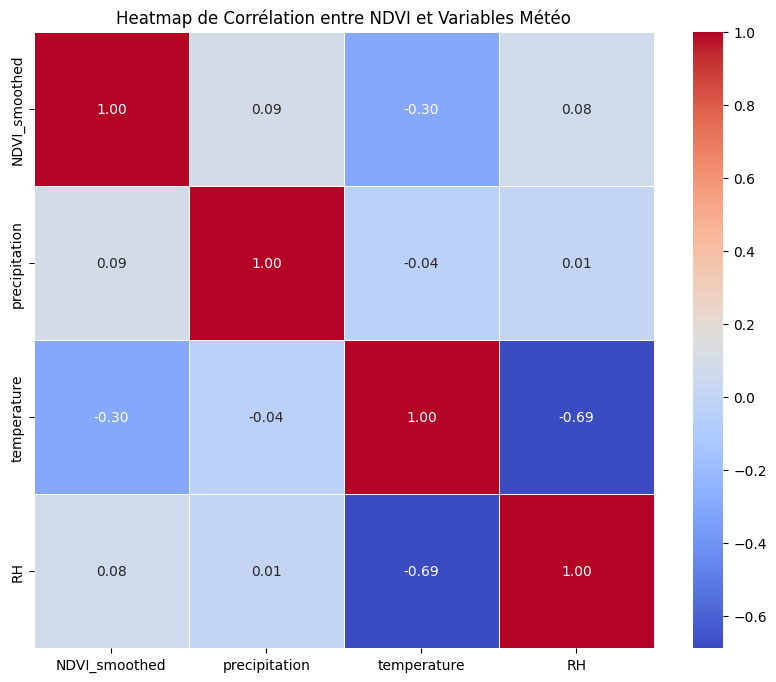

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Au cas o√π

# Assurez-vous que df_all est votre DataFrame final fusionn√© et nettoy√©.
# Si vous l'avez appel√© df_all_cleaned ou df_all_nettoye, utilisez ce nom.
VOTRE_DATAFRAME_NETTOYE = df_all_cleaned

# S√©lectionner uniquement les colonnes num√©riques pertinentes pour la corr√©lation
# Si 'NDVI' (brut) est encore l√† et que vous pr√©f√©rez analyser avec 'NDVI_smoothed',
# vous pouvez l'exclure ou s√©lectionner explicitement les colonnes.
colonnes_pour_correlation = ['NDVI_smoothed', 'precipitation', 'temperature', 'RH']
df_pour_correlation = VOTRE_DATAFRAME_NETTOYE[colonnes_pour_correlation]

# Calculer la matrice de corr√©lation
matrice_correlation = df_pour_correlation.corr()

print("Matrice de Corr√©lation :")
print(matrice_correlation)

# Visualiser la matrice de corr√©lation avec une heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrice_correlation,
            annot=True,        # Afficher les valeurs de corr√©lation sur la carte
            cmap='coolwarm',   # Palette de couleurs (bleu pour n√©gatif, rouge pour positif)
            fmt=".2f",         # Formatage des nombres √† 2 d√©cimales
            linewidths=.5)     # Lignes pour s√©parer les cellules
plt.title('Heatmap de Corr√©lation entre NDVI et Variables M√©t√©o')
plt.show()

# Sauvegarder la heatmap (optionnel)
nom_fichier_heatmap = "heatmap_correlation_fes_meknes.png"
# plt.savefig(nom_fichier_heatmap, dpi=300, bbox_inches='tight') # D√©commentez pour sauvegarder
# print(f"‚úÖ Heatmap sauvegard√©e avec succ√®s sous le nom : {nom_fichier_heatmap}")




Matrice de Corr√©lation avec d√©calage temporel (focus sur NDVI):
NDVI_smoothed          1.000000
temperature_lag30      0.646660
RH_lag7                0.394546
RH_lag15               0.355667
RH_lag60               0.345239
RH                     0.112053
precipitation          0.091995
precipitation_lag45    0.038690
precipitation_lag60    0.026594
RH_lag45               0.023398
precipitation_lag15   -0.025249
precipitation_lag30   -0.074825
temperature_lag45     -0.141297
temperature           -0.287491
RH_lag30              -0.315983
temperature_lag15     -0.426555
temperature_lag60     -0.536069
temperature_lag7      -0.706630
Name: NDVI_smoothed, dtype: float64


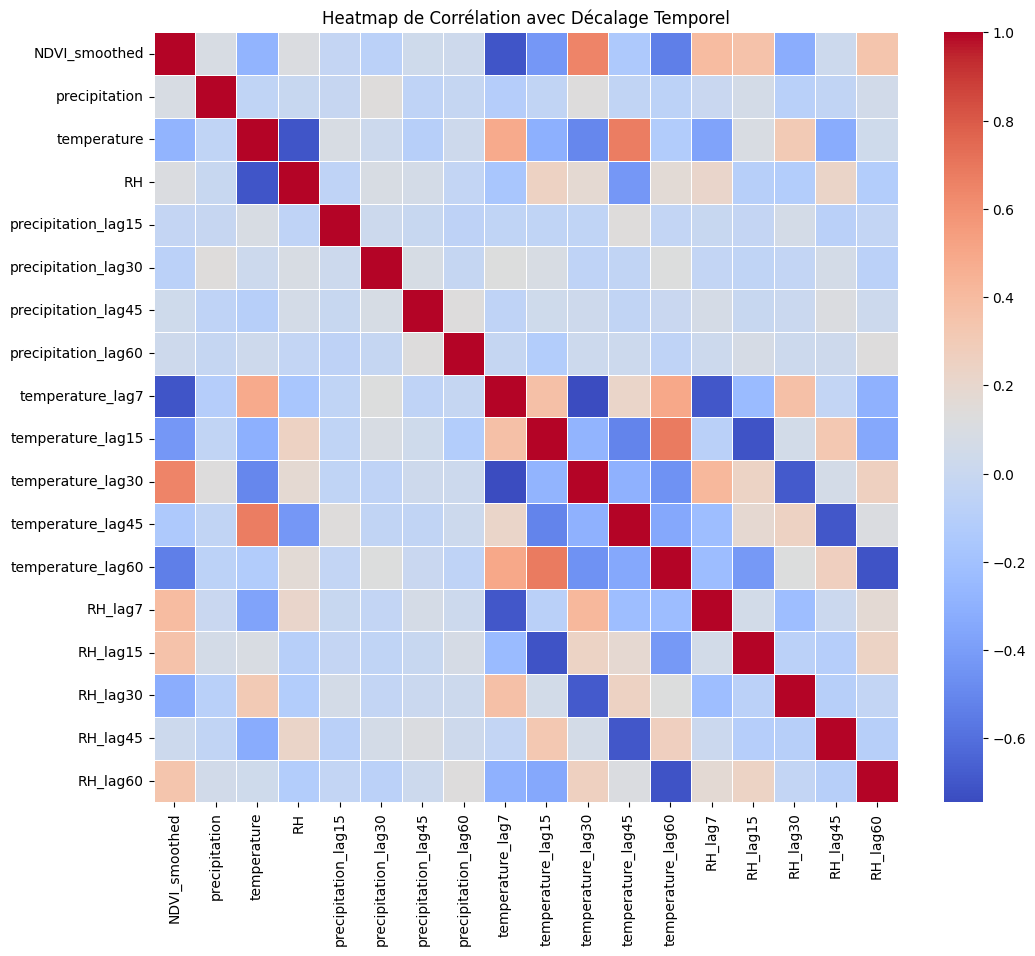

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Si vous avez utilis√© un autre nom comme 'df_all_cleaned', utilisez celui-l√†.
VOTRE_DATAFRAME_NETTOYE = df_all_cleaned

# Cr√©ez une copie pour √©viter de modifier le DataFrame original
df_lag = VOTRE_DATAFRAME_NETTOYE.copy()

# D√©finissez les d√©calages  (en jours)
# Par exemple, 15 jours, 30 jours (environ 1 mois), 45 jours, 60 jours
lags_precipitation = [15, 30, 45, 60]
lags_temperature = [7, 15, 30,45 , 60] # L'effet de la temp√©rature peut √™tre un peu plus rapide ou √©galement d√©cal√©
lags_rh = [7, 15, 30, 45 , 60] # Similaire pour l'HR

for lag in lags_precipitation:
    df_lag[f'precipitation_lag{lag}'] = df_lag['precipitation'].shift(lag)

for lag in lags_temperature:
    df_lag[f'temperature_lag{lag}'] = df_lag['temperature'].shift(lag)

for lag in lags_rh:
    df_lag[f'RH_lag{lag}'] = df_lag['RH'].shift(lag)

# Colonnes √† inclure dans la nouvelle matrice de corr√©lation
colonnes_pour_lag_correlation = ['NDVI_smoothed', 'precipitation', 'temperature', 'RH'] + \
                                [f'precipitation_lag{lag}' for lag in lags_precipitation] + \
                                [f'temperature_lag{lag}' for lag in lags_temperature] + \
                                [f'RH_lag{lag}' for lag in lags_rh]

# Supprimer les lignes avec des valeurs NaN qui ont √©t√© cr√©√©es par l'op√©ration de d√©calage
df_lag_cleaned = df_lag.dropna(subset=colonnes_pour_lag_correlation) # S'assurer de ne consid√©rer que les lignes o√π toutes ces valeurs sont pr√©sentes

# Recalculer la matrice de corr√©lation
matrice_correlation_lag = df_lag_cleaned[colonnes_pour_lag_correlation].corr()

print("\nMatrice de Corr√©lation avec d√©calage temporel (focus sur NDVI):")
# Afficher les corr√©lations de NDVI_smoothed avec toutes les autres variables
print(matrice_correlation_lag['NDVI_smoothed'].sort_values(ascending=False))

# Visualiser la matrice de corr√©lation d√©cal√©e compl√®te (optionnel, peut √™tre grande)
plt.figure(figsize=(12, 10)) # Ajustez la taille si besoin
sns.heatmap(matrice_correlation_lag, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5) # annot=False pour la lisibilit√© si trop de variables
plt.title('Heatmap de Corr√©lation avec D√©calage Temporel')
plt.show()

## interpretation



temperature_lag30 : 0.646660 (Forte corr√©lation positive).
 C'est la corr√©lation la plus √©lev√©e et un changement majeur par rapport √† la corr√©lation n√©gative observ√©e sans d√©calage (-0.287).
 Cela sugg√®re fortement que des temp√©ratures plus chaudes observ√©es environ un mois avant sont associ√©es √† un NDVI plus √©lev√©. Cela pourrait correspondre √† la p√©riode de croissance o√π la chaleur (pas excessive) et l'ensoleillement favorisent la v√©g√©tation, apr√®s d'√©ventuelles pluies printani√®res.

RH_lag7 : 0.394546 (Corr√©lation positive mod√©r√©e)
RH_lag15 : 0.355667 (Corr√©lation positive mod√©r√©e)
RH_lag60 : 0.345239 (Corr√©lation positive mod√©r√©e) Ces r√©sultats indiquent qu'une humidit√© relative plus √©lev√©e dans les 7 √† 60 jours pr√©c√©dents est b√©n√©fique pour la v√©g√©tation.
RH (sans d√©calage) : 0.112053 (Faible corr√©lation positive, l√©g√®rement meilleure que le 0.08 initial).
precipitation (sans d√©calage) : 0.091995 (Faible corr√©lation positive, similaire au 0.09 initial).
precipitation_lag45 et precipitation_lag60 : Tr√®s faibles corr√©lations positives (autour de 0.03-0.04).
RH_lag45 : 0.023398 (Tr√®s faible corr√©lation positive).

precipitation_lag15 et precipitation_lag30 : Corr√©lations quasi nulles ou faiblement n√©gatives (-0.025 et -0.075). Les pr√©cipitations, m√™me avec un d√©calage, ne montrent toujours pas de corr√©lation lin√©aire forte avec le NDVI au jour le jour. C'est un point important. Cela ne signifie pas que la pluie n'est pas importante, mais que la relation n'est peut-√™tre pas lin√©aire, ou que des accumulations sur des p√©riodes plus longues (plut√¥t que la pluie d'un jour pr√©cis X jours avant) seraient plus pertinentes.
temperature_lag45 : -0.141297 (Faible corr√©lation n√©gative).
temperature (sans d√©calage) : -0.287491 (Corr√©lation n√©gative mod√©r√©e, similaire au -0.30 initial).
RH_lag30 : -0.315983 (Corr√©lation n√©gative mod√©r√©e). C'est int√©ressant car l'HR sans d√©calage et avec des d√©calages plus courts √©tait positive. Un mois apr√®s une p√©riode d'humidit√© √©lev√©e, le NDVI pourrait √™tre plus bas si cette humidit√© √©tait, par exemple, associ√©e √† moins d'ensoleillement ou √† la fin d'une saison humide.
temperature_lag15 : -0.426555 (Corr√©lation n√©gative mod√©r√©e, plus forte que sans d√©calage).
temperature_lag60 : -0.536069 (Corr√©lation n√©gative mod√©r√©e √† forte).
temperature_lag7 : -0.706630 (Forte corr√©lation n√©gative). C'est la deuxi√®me corr√©lation la plus forte. Elle sugg√®re que des temp√©ratures plus basses observ√©es une semaine avant sont fortement associ√©es √† un NDVI plus √©lev√©. Cela pourrait indiquer que des temp√©ratures mod√©r√©es ou une baisse de temp√©rature apr√®s une p√©riode chaude sont b√©n√©fiques.
Observations Cl√©s et Implications :

R√¥le Complexe de la Temp√©rature :

La corr√©lation la plus forte et positive est avec temperature_lag30 (0.65).
La corr√©lation la plus forte et n√©gative est avec temperature_lag7 (-0.71). Cela indique que la relation entre la temp√©rature et le NDVI n'est pas simple. Des temp√©ratures plus fra√Æches une semaine avant semblent bonnes (peut-√™tre moins de stress hydrique), mais une p√©riode globalement plus chaude un mois avant (peut-√™tre le d√©but/milieu de la saison de croissance) est √©galement positive. Cela met en √©vidence l'importance des cycles saisonniers.
Pr√©cipitations : L'impact direct de la pluie journali√®re, m√™me d√©cal√©e, reste faible dans cette analyse. Il serait peut-√™tre plus judicieux d'analyser des cumuls de pr√©cipitations sur plusieurs semaines ou mois.

Humidit√© Relative : Une HR √©lev√©e dans les 7-15 jours pr√©c√©dents montre un impact positif mod√©r√©, ce qui est intuitif.

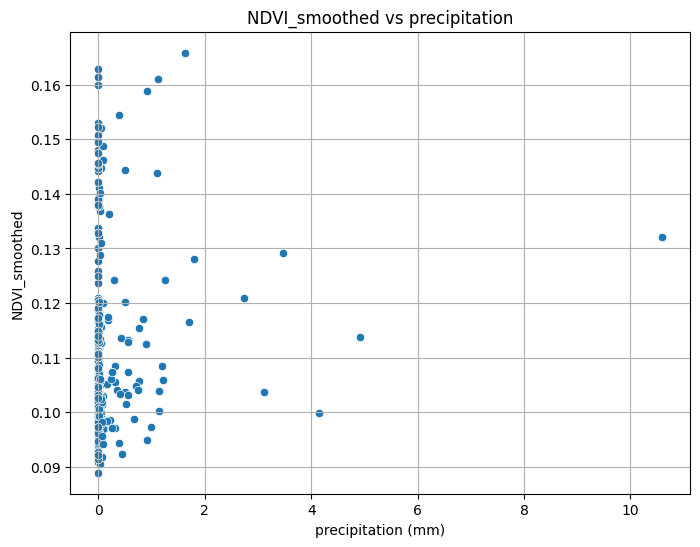

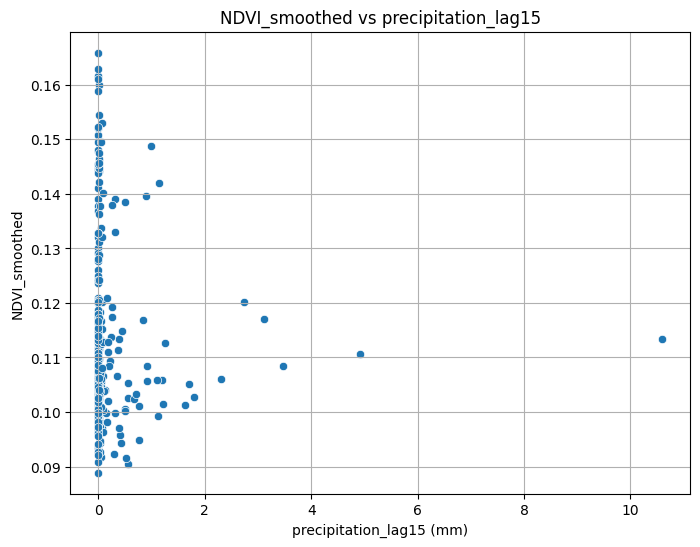

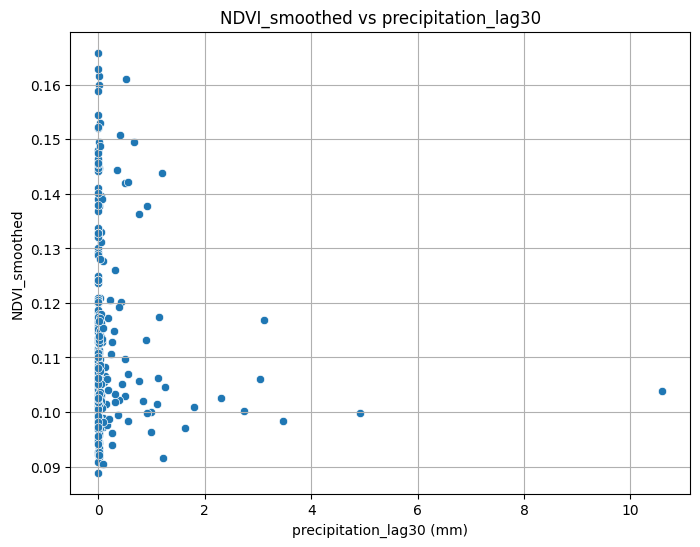

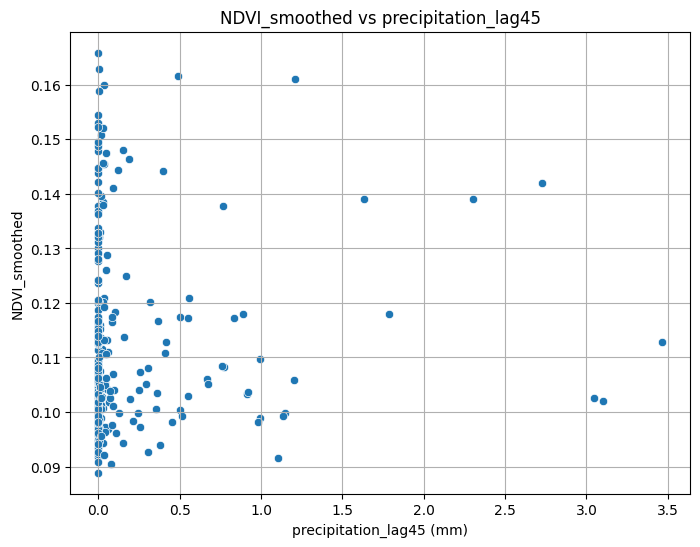

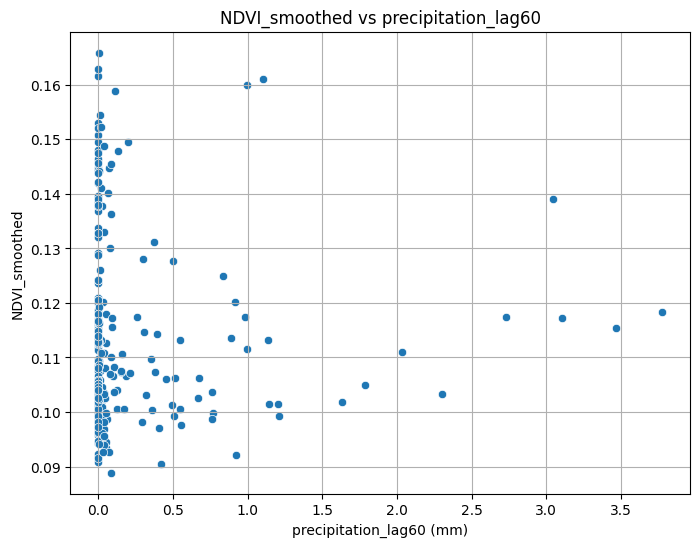

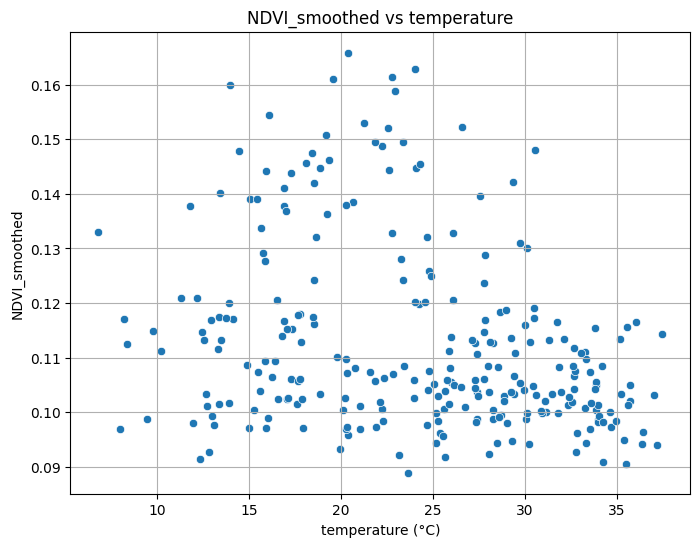

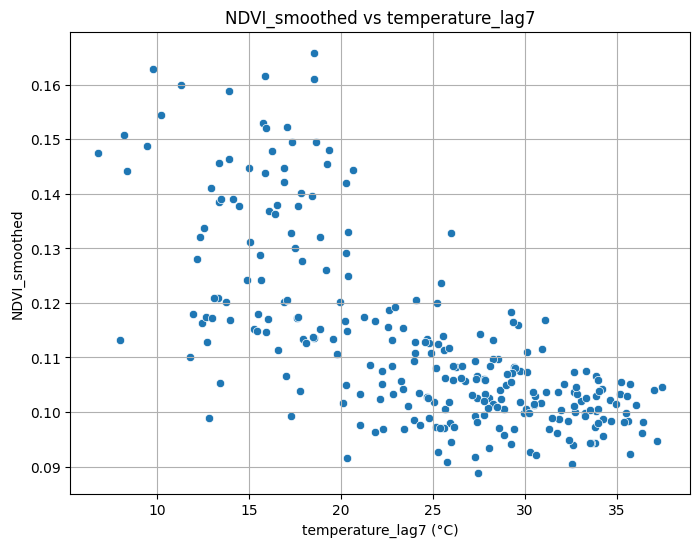

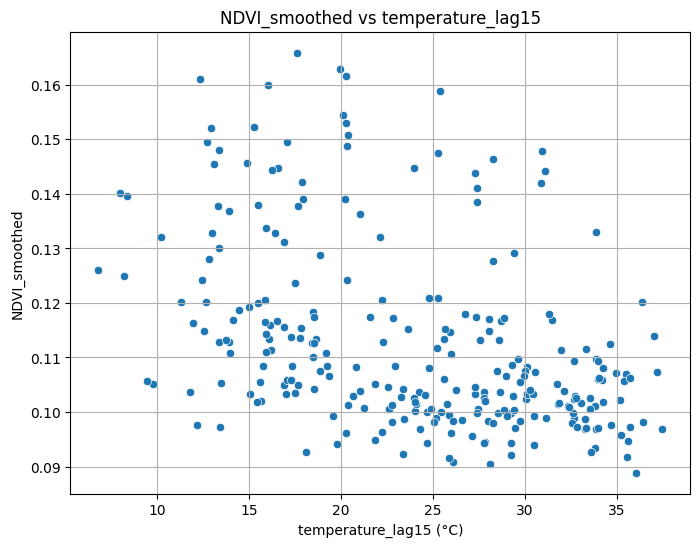

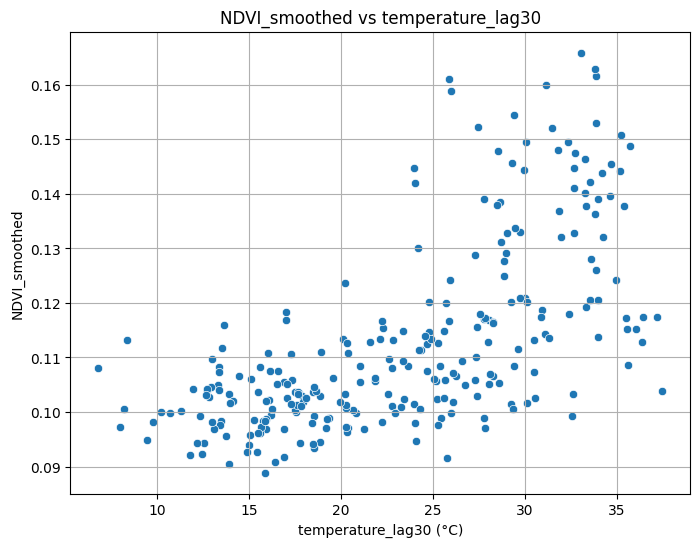

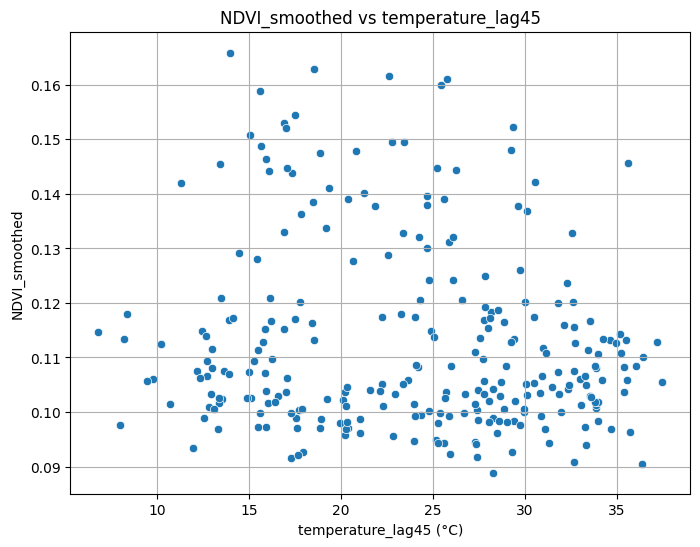

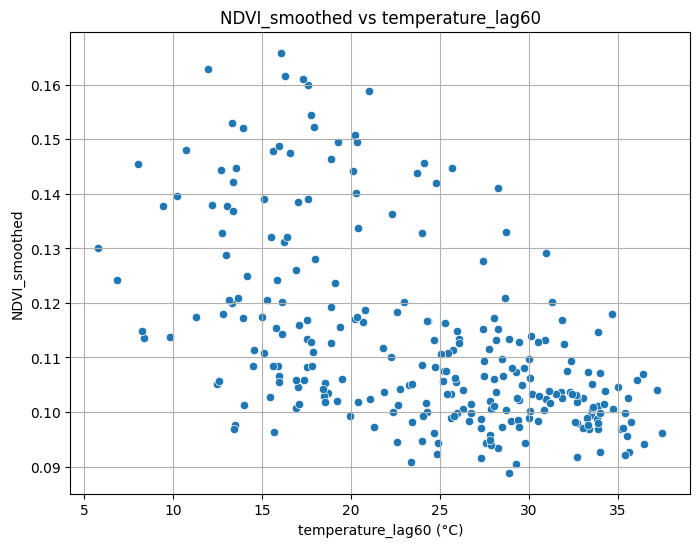

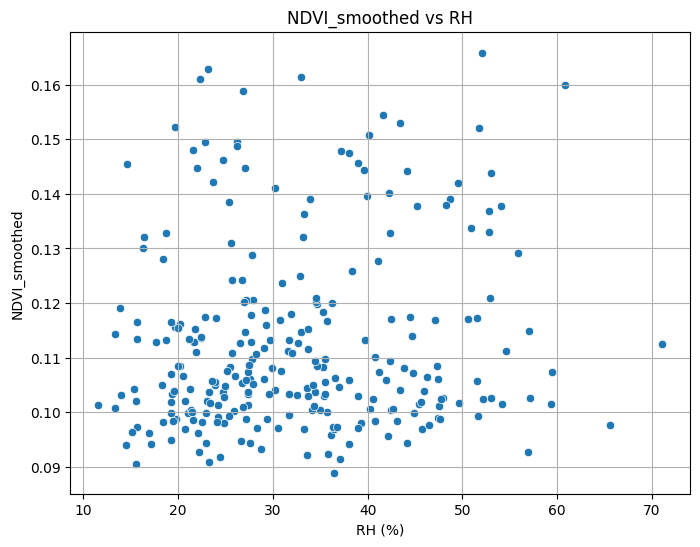

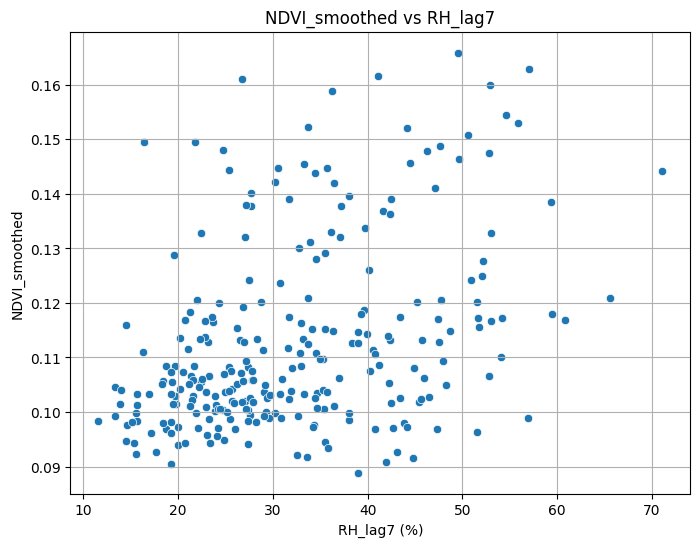

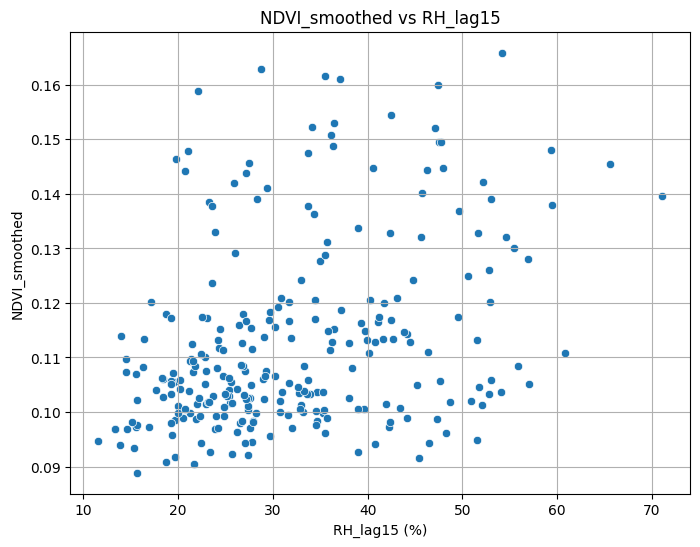

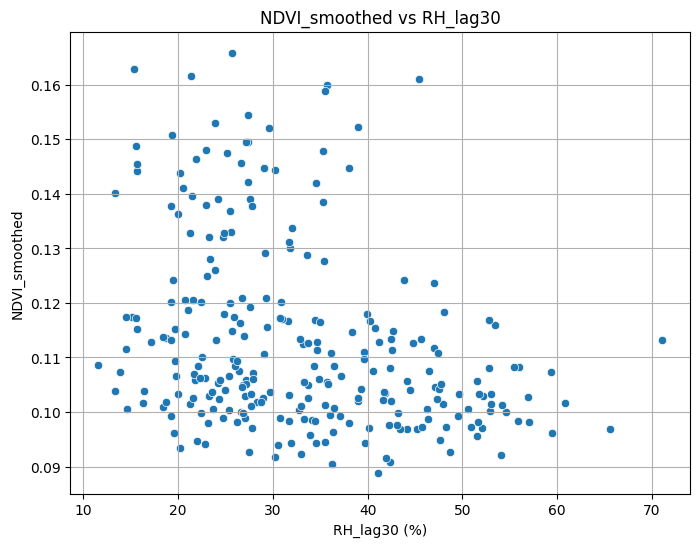

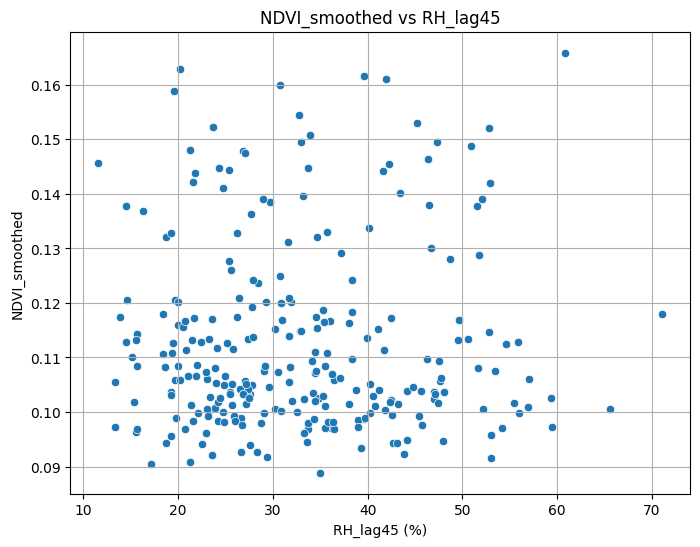

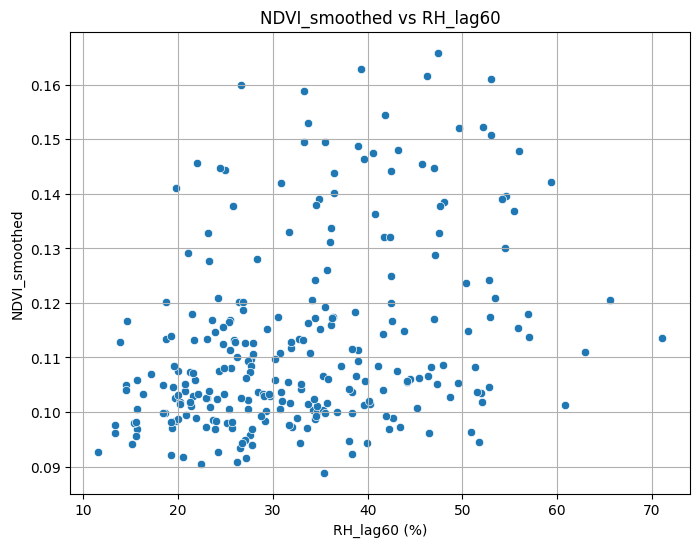

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  s

# Assurez-vous que df_lag_cleaned est votre DataFrame final
# contenant NDVI_smoothed et toutes les variables m√©t√©orologiques d√©cal√©es,
# et qu'il a √©t√© nettoy√© des NaN introduits par .shift()
VOTRE_DATAFRAME_AVEC_LAGS_NETTOYE = df_lag_cleaned

# Liste des variables m√©t√©orologiques (originales et d√©cal√©es) √† comparer avec NDVI_smoothed
# Bas√© sur votre sortie de matrice de corr√©lation pr√©c√©dente
variables_a_comparer = [
    'precipitation', 'precipitation_lag15', 'precipitation_lag30', 'precipitation_lag45', 'precipitation_lag60',
    'temperature', 'temperature_lag7', 'temperature_lag15', 'temperature_lag30', 'temperature_lag45', 'temperature_lag60',
    'RH', 'RH_lag7', 'RH_lag15', 'RH_lag30', 'RH_lag45', 'RH_lag60'
]

# Variable cible
variable_cible = 'NDVI_smoothed'

# Boucle pour cr√©er un nuage de points pour chaque relation
for var_compare in variables_a_comparer:
    # V√©rifier si la colonne existe dans le DataFrame pour √©viter les erreurs
    if var_compare in VOTRE_DATAFRAME_AVEC_LAGS_NETTOYE.columns:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=VOTRE_DATAFRAME_AVEC_LAGS_NETTOYE[var_compare], y=VOTRE_DATAFRAME_AVEC_LAGS_NETTOYE[variable_cible])

        # Titre et labels
        titre_graphique = f'{variable_cible} vs {var_compare}'
        label_x = f'{var_compare}'
        if 'temperature' in var_compare:
            label_x += ' (¬∞C)'
        elif 'precipitation' in var_compare:
            label_x += ' (mm)'
        elif 'RH' in var_compare:
            label_x += ' (%)'

        plt.title(titre_graphique)
        plt.xlabel(label_x)
        plt.ylabel(variable_cible)
        plt.grid(True)
        plt.show()
    else:
        print(f"Attention : La colonne '{var_compare}' n'a pas √©t√© trouv√©e dans le DataFrame.")